## Setup in Local Machine (all)

In [ ]:
#Install
%pip install worker
%pip install pandas
%pip install numpy
%pip install networkx
%pip install matplotlib
%pip install music21
%pip install musescore
%pip install tslearn
%pip install sklearn
%pip install multiprocessing
%pip install pyvis

In [1]:
# Import
import worker
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from music21 import *
from music21 import converter, corpus, environment
from tslearn.metrics import dtw
from multiprocessing import Pool, Manager, cpu_count
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances
from networkx.algorithms.cuts import conductance
from pyvis.network import Network
from IPython.core.display import display, HTML

C:\Users\AL\AppData\Local\Temp\ipykernel_5724\995332593.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Path
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe' # Change if needed
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe' # Change if needed

## Process Sample Music

In [3]:
# get notes function
def get_notes(score):
    element_array = []
    for part in score.parts:
        for element in part.flatten():
            element_array.append(element)
    return element_array

In [4]:
# get array of notes (simplified; lightweight)
midi = 'bach_846.mid' # this midi was cleaned
score = converter.parse(midi)
notes = get_notes(score)

In [7]:
# midi to nmat function
def midi_to_nmat(midi_file):
  s = converter.parse(midi_file)
  nmat = pd.DataFrame(columns=['onset_beats', 'duration_beats', 'midi_pitch'])
  onset = 0
  for el in s.flatten().notes:
    if isinstance(el, chord.Chord):
      row = [el.offset, el.duration.quarterLength, el.root().midi]
    else:
      row = [el.offset, el.duration.quarterLength, el.pitch.midi]
    nmat.loc[len(nmat)] = row
    onset += el.seconds
  return nmat

In [8]:
# convert a sample midi to nmat 
nmat = midi_to_nmat(midi)
nmat.head(10)

,onset_beats,duration_beats,midi_pitch
0,0.00,2.00,60.0
1,0.25,1.75,64.0
2,0.50,0.25,67.0
3,0.75,0.25,72.0
4,1.00,0.25,76.0
5,1.25,0.25,67.0
6,1.50,0.25,72.0
7,1.75,0.25,76.0
8,2.00,2.00,60.0
9,2.25,1.75,64.0


## Implication-Realization Ruleset, Assignment and Score Visualization

In [10]:
# IR symbol calculation function
def calculate_ir_symbol(interval1, interval2, threshold=5):
    direction = interval1 * interval2
    abs_difference = abs(interval2-interval1)
    # Process
    if direction > 0 and (abs(interval2-interval1))<threshold:
        return 'P'  
    # IR2: D (Duplication)
    elif interval1 == interval2 == 0:
        return 'D' 
    # IR3: IP (Intervallic Process)
    elif ((interval1 * interval2)<0) and (-threshold <= (abs(interval2) - abs(interval1)) <= threshold) and (abs(interval2) != abs(interval1)):
        return 'IP' 
    # IR4: ID (Intervallic Duplication)
    elif ((interval1 * interval2) < 0) and (abs(interval2) == abs(interval1)):
        return 'ID'   
    # IR5: VP (Vector Process)
    elif (interval1 * interval2 > 0) and (abs(interval2-interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VP'
    # IR6: R (Reveral)
    elif (interval1 * interval2 < 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'R'
    # IR7: IR (Intervallic Reveral)
    elif (interval1 * interval2 > 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'IR' 
    # IR8: VR (Vector Reveral)
    elif (interval1 * interval2 < 0) and (abs(interval2 - interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VR'
    elif interval2 == 0 and not (interval1 < -5 or interval1 > 5):
        return 'IP'
    elif interval2 == 0 and (interval1 < -5 or interval1 > 5):
        return 'R'
    elif interval1 == 0 and not (interval2 < -5 or interval2 > 5):
        return 'P'
    elif interval1 == 0 and (interval2 < -5 or interval2 > 5):
        return 'VR'

In [11]:
# assign IR symbol function 
def assign_ir_symbols(elements):
    symbols = []
    current_group = [] 
    group_pitches = []
    
    color_map = {
        'P': 'blue',        # IR1: P (Process) 
        'D': 'green',       # IR2: D (Duplication)
        'IP': 'red',        # IR3: IP (Intervallic Process)
        'ID': 'orange',     # IR4: ID (Intervallic Duplication)
        'VP': 'purple',     # IR5: VP (Vector Process)
        'R': 'cyan',        # IR6: R (Reveral)
        'IR': 'magenta',    # IR7: IR (Intervallic Reveral)
        'VR': 'yellow',     # IR8: VR (Vector Reveral)
        'M': 'pink',        # IR9: M (Monad)
        'd': 'lime',        # IR10 d (Dyad)
    }

    def evaluate_current_group():
        if len(current_group) == 3:
            interval1 = group_pitches[1] - group_pitches[0]
            interval2 = group_pitches[2] - group_pitches[1]
            symbol = calculate_ir_symbol(interval1, interval2)
            # symbols.append(symbol)
            color = color_map.get(symbol, 'black')  # Default to black if symbol is not predefined
            symbols.extend((note, symbol, color) for note in current_group)
        elif len(current_group) == 2:
            # symbols.append('d')  # Dyad
            symbols.extend((note, 'd', color_map['d']) for note in current_group)
        elif len(current_group) == 1:
            # symbols.append('M')  # Monad
            symbols.extend((note, 'M', color_map['M']) for note in current_group)
        else:
            symbols.append('Error: Invalid note object')
        current_group.clear()
        group_pitches.clear()

    for element in elements:
        if isinstance(element, note.Note):
            current_group.append(element)
            group_pitches.append(element.pitch.ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, chord.Chord):
            current_group.append(element)
            group_pitches.append(element.root().ps)
            if len(current_group) == 3:
                evaluate_current_group()
        elif isinstance(element, note.Rest):
            continue
            # # Remove continue for visualization
            # rest_tuple = (element, 'rest', 'black') 
            # evaluate_current_group()
            # symbols.append(rest_tuple)
        else:
            if current_group:
                evaluate_current_group()

    # Handle any remaining notes
    if current_group:
        evaluate_current_group()

    return symbols

In [12]:
# Score visualization function
def visualize_notes_with_symbols(notes_with_symbols):
    s = stream.Score()
    part = stream.Part()
    for note, symbol, color in notes_with_symbols:
        print(note, symbol, color)
        note.style.color = color
        note.lyric = symbol
        part.append(note)
    s.append(part)
    s.show()

In [25]:
# check to see difference in notes vs nmat format
for note in notes:
    print(note)

# for note in nmat:
#     print(note)   

bach_846.mid


<music21.note.Note G> d lime
<music21.note.Note C> d lime
<music21.note.Note E> M pink
<music21.note.Note G> P blue
<music21.note.Note C> P blue
<music21.note.Note E> P blue
<music21.note.Note G> P blue
<music21.note.Note C> P blue
<music21.note.Note E> P blue
<music21.note.Note G> P blue
<music21.note.Note C> P blue
<music21.note.Note E> P blue
<music21.note.Note A> M pink
<music21.note.Note D> M pink
<music21.note.Note F> M pink
<music21.note.Note A> P blue
<music21.note.Note D> P blue
<music21.note.Note F> P blue
<music21.note.Note A> M pink
<music21.note.Note D> M pink
<music21.note.Note F> M pink
<music21.note.Note A> d lime
<music21.note.Note D> d lime
<music21.note.Note F> M pink
<music21.note.Note G> M pink
<music21.note.Note D> M pink
<music21.note.Note F> M pink
<music21.note.Note G> P blue
<music21.note.Note D> P blue
<music21.note.Note F> P blue
<music21.note.Note G> M pink
<music21.note.Note D> M pink
<music21.note.Note F> M pink
<music21.note.Note G> d lime
<music21.note.

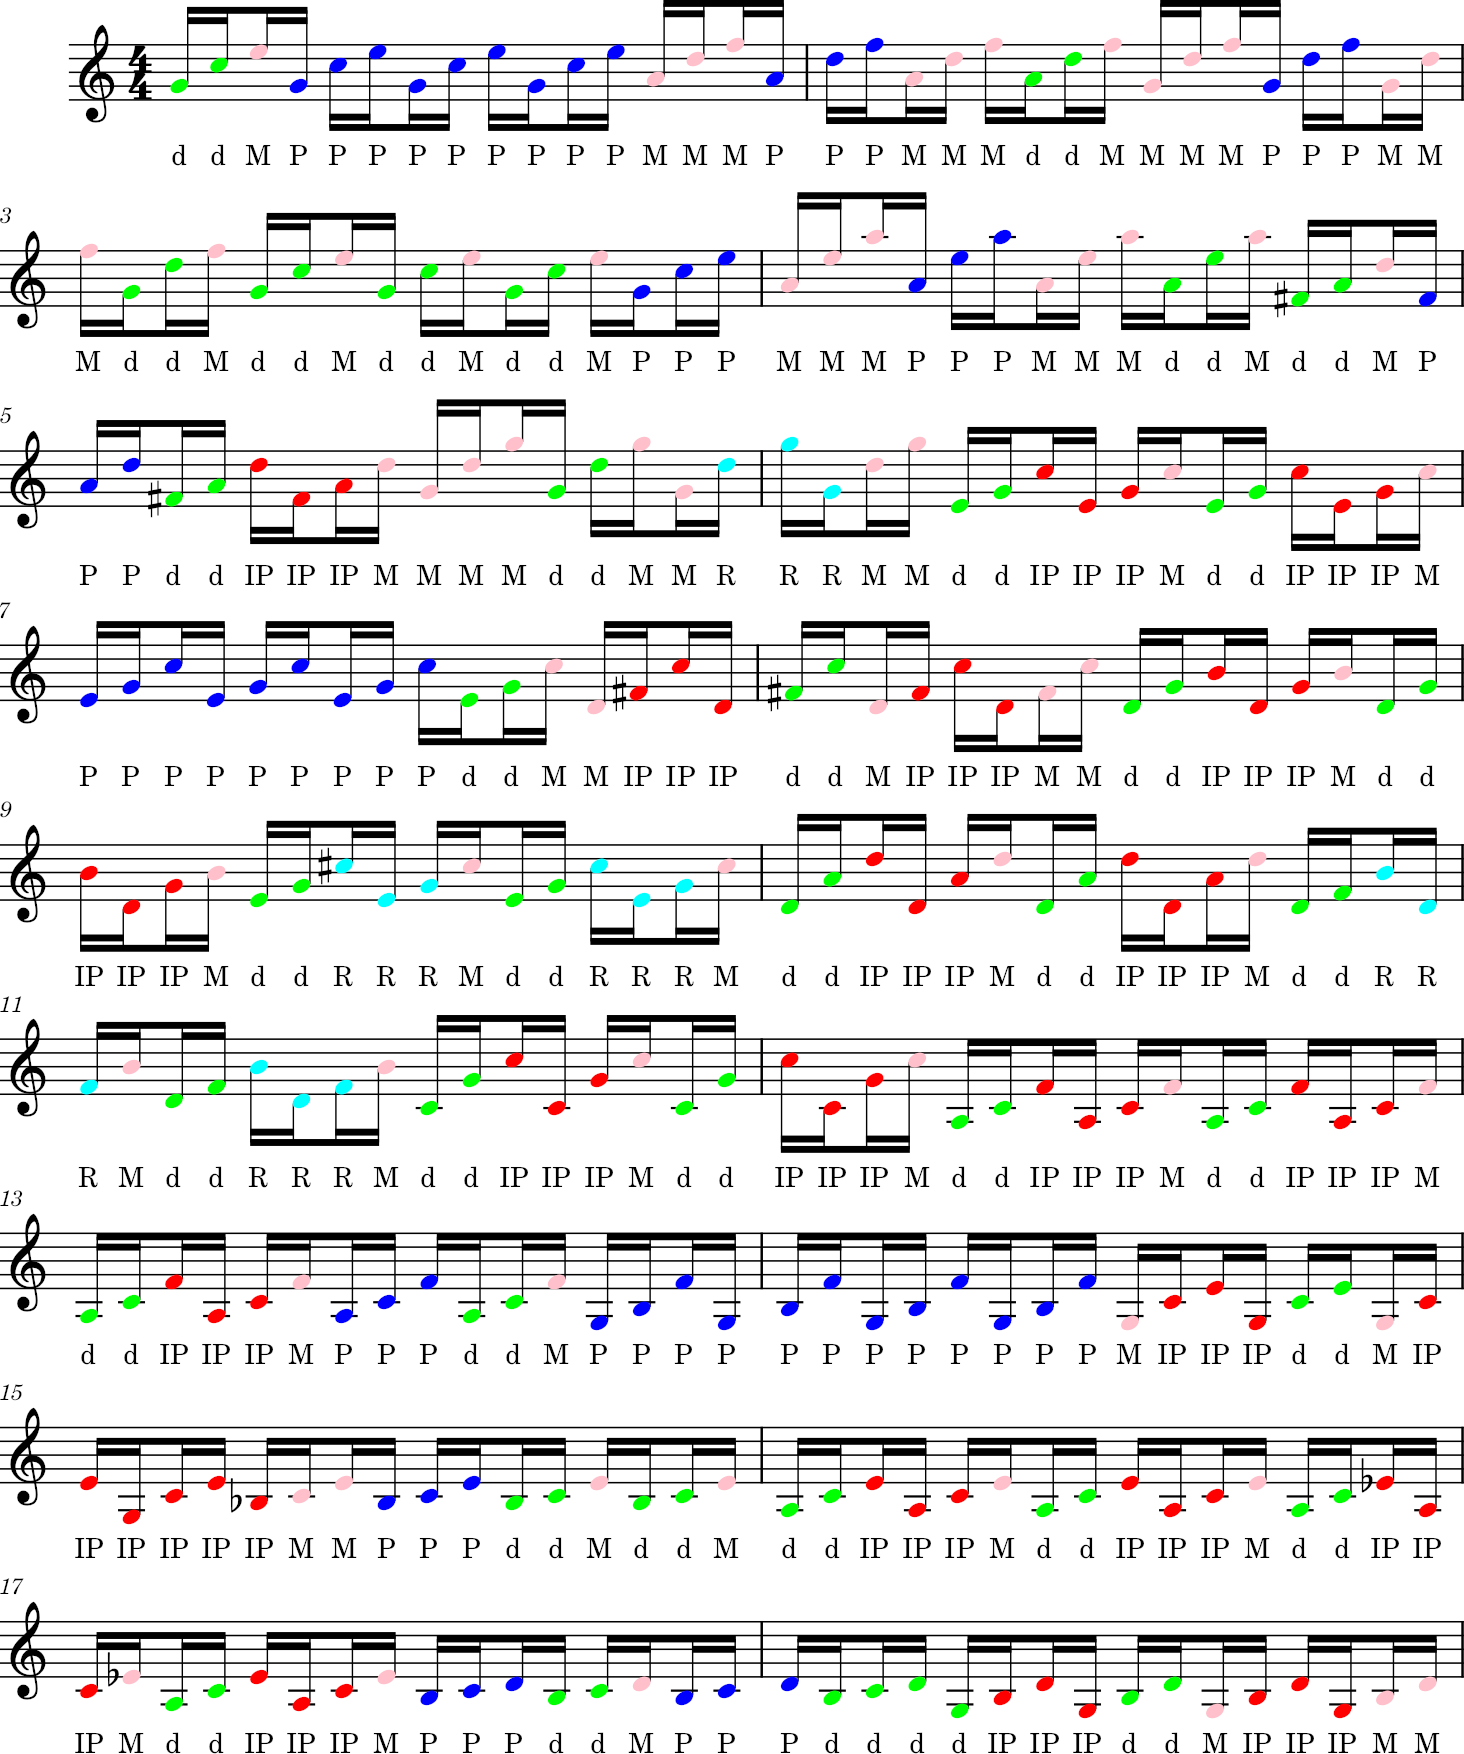

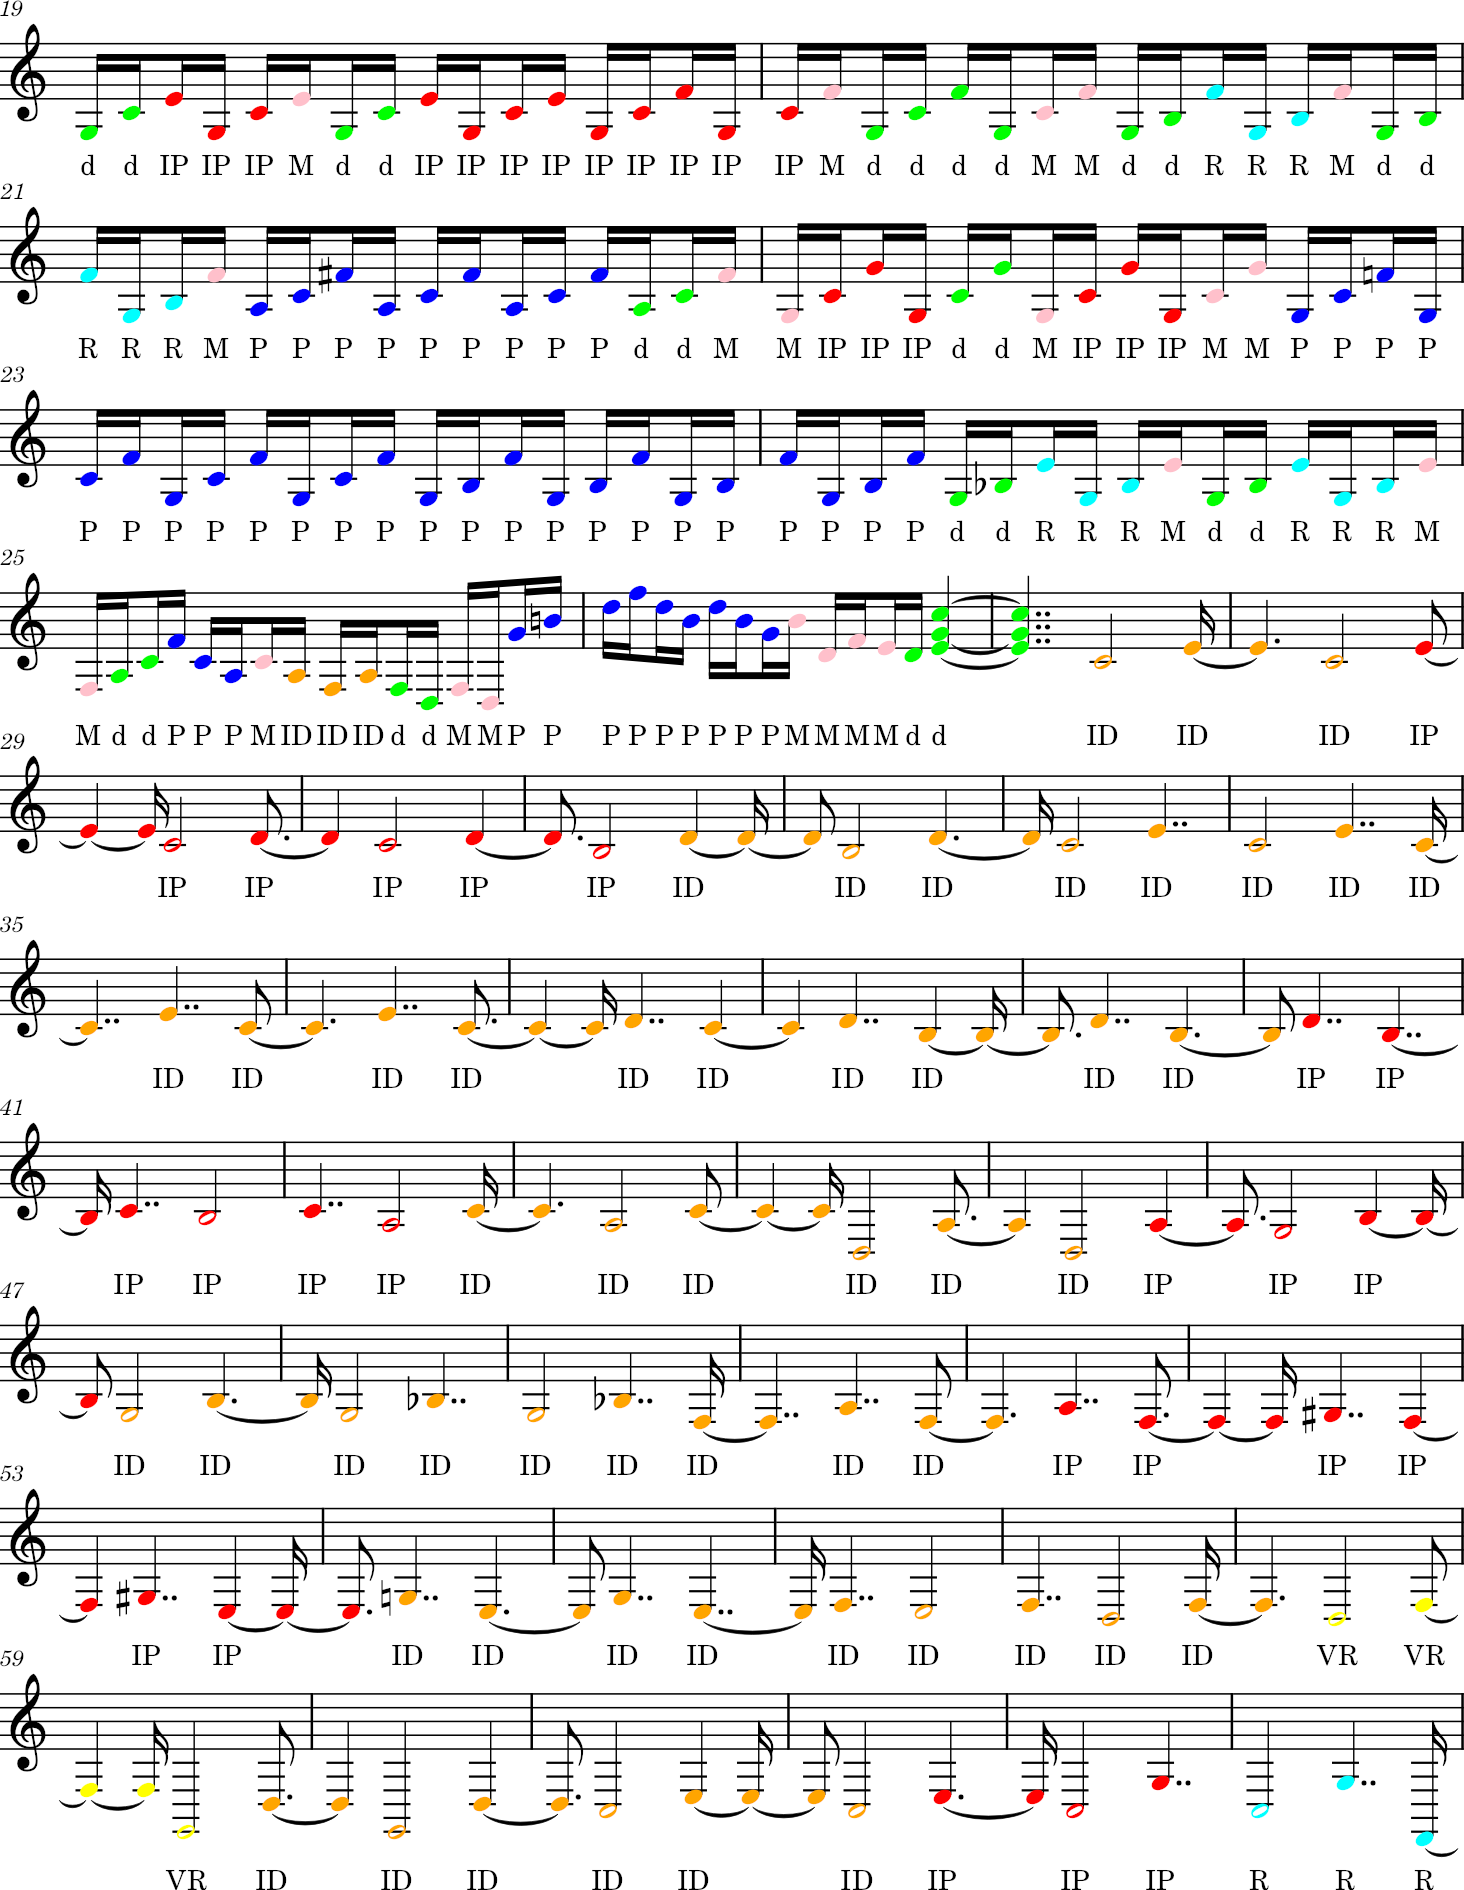

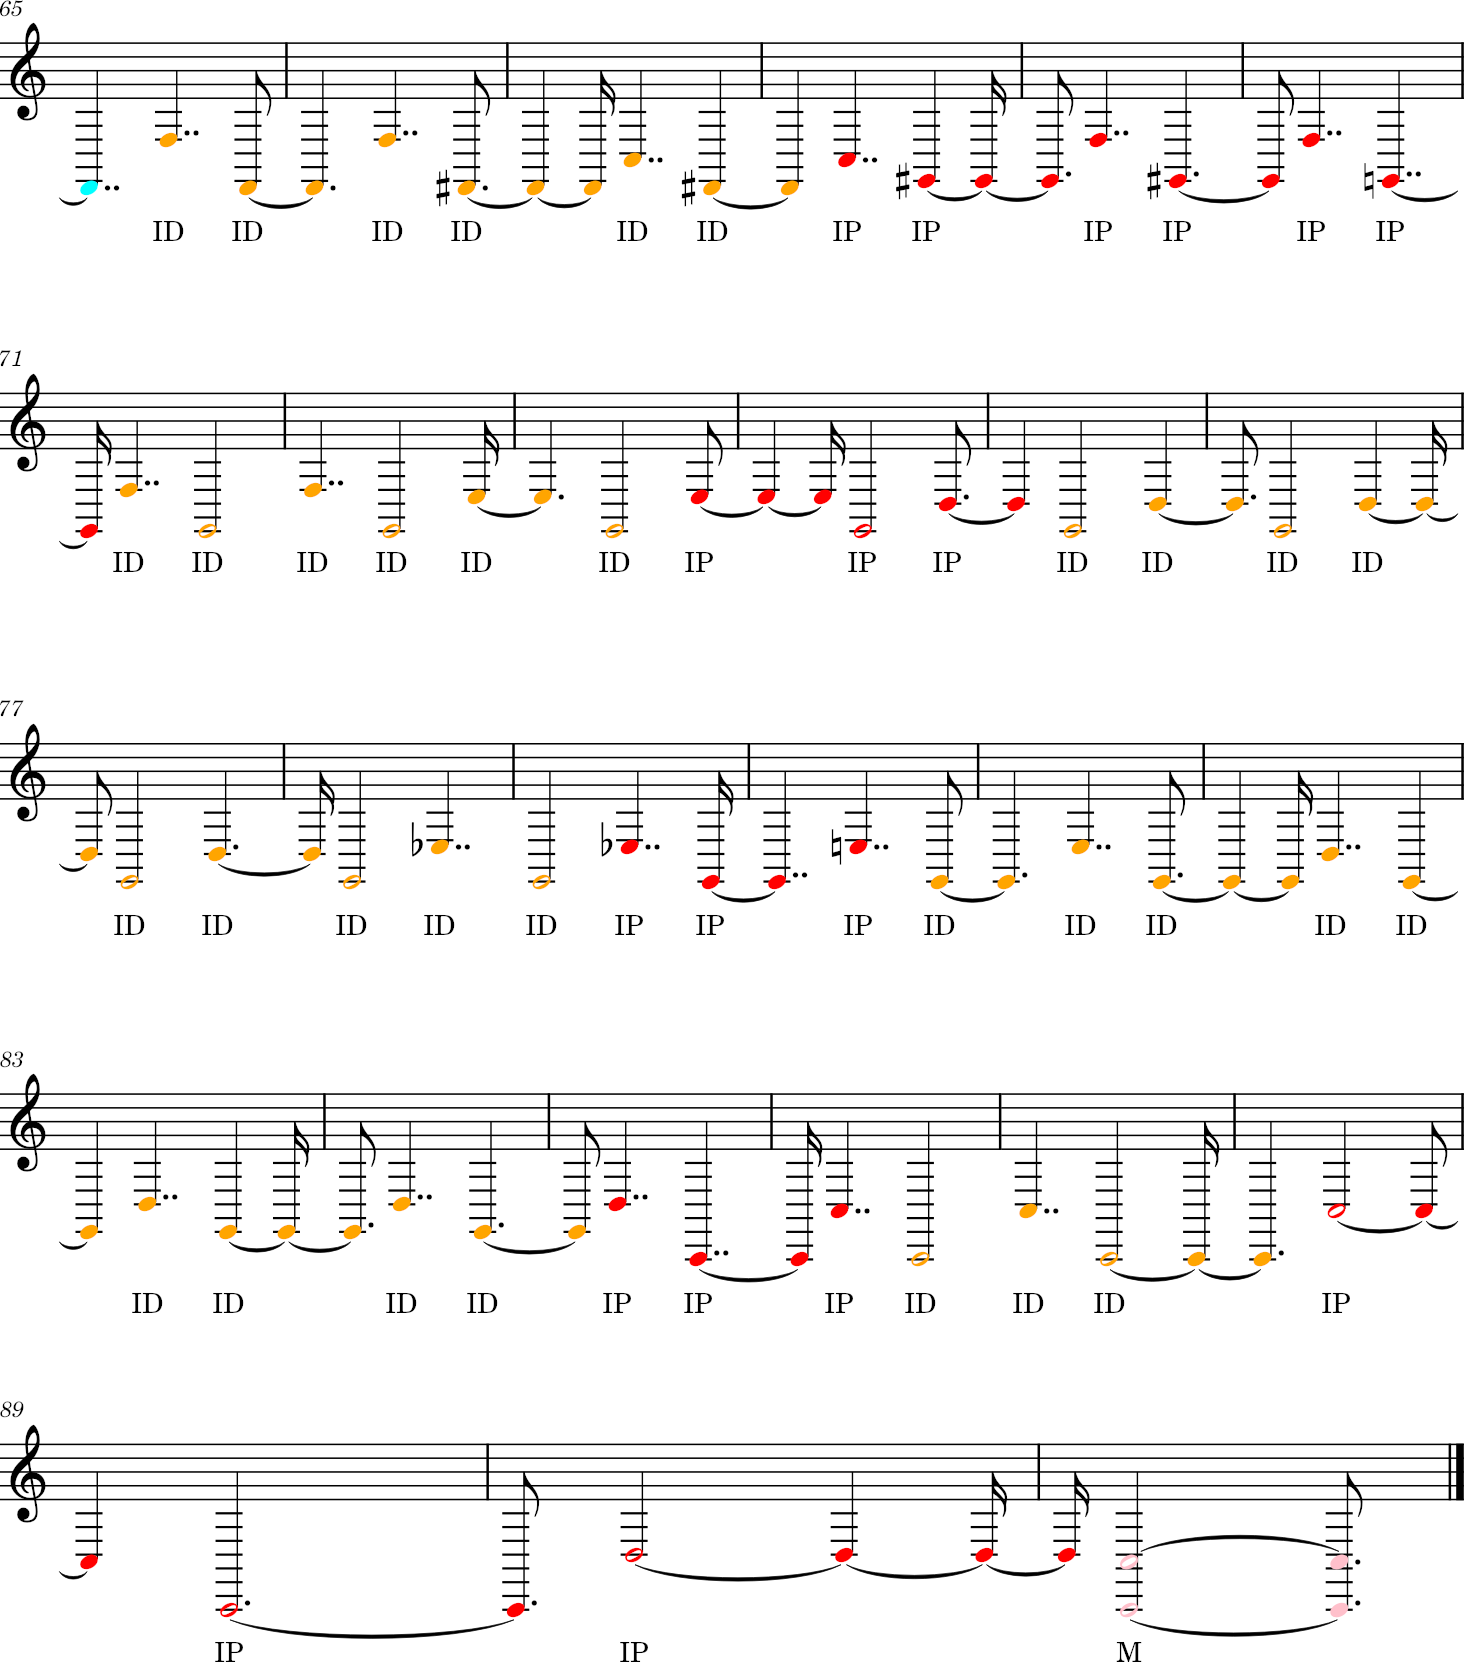

In [14]:
# Usage of the above functions
# test_ir = assign_ir_symbols(nmat) # try using the note matrix
test_ir = assign_ir_symbols(notes)

try: # error when polyphonic
    visualize_notes_with_symbols(test_ir)
except:
    score.show()

## Gestalt Based Segmentation (Functions)

In [42]:
# onset function
def get_onset(notematrix: pd.DataFrame, timetype='beat'):
  if timetype == 'beat':
    return notematrix['onset_beats']
  elif timetype == 'sec':
    return notematrix['onset_sec']
  else:
    ValueError(f"Invalid timetype: {timetype}. Choices are only 'beat' and 'sec'")

In [43]:
# duration function
def get_duration(notematrix: pd.DataFrame, timetype='beat') -> pd.Series:
  if timetype == 'beat':
    return notematrix['duration_beats']
  elif timetype == 'sec':
    return notematrix['duration_sec']
  else:
    ValueError(f"Invalid timetype: {timetype}. Choices are only 'beat' and 'sec'")

In [44]:
# clang boundary calculation funtion
def calculate_clang_boundaries(notematrix: pd.DataFrame):
  cl = 2*(get_onset(notematrix).diff() + get_duration(notematrix).shift(-1)) + abs(notematrix['midi_pitch'].diff())
  clb = (cl.shift(-1) > cl) & (cl.shift(1) > cl)
  clind = clb.index[clb].tolist()
  return clind

In [45]:
# segment boundary calculation function
def calculate_segment_boundaries(notematrix, clind):
    first = [0] + clind
    last = clind + [len(notematrix) - 1]
    mean_pitch = [notematrix.iloc[first[i]:last[i]+1]['midi_pitch'].mean() for i in range(len(first))]
    segdist = []
    for i in range(1, len(first)):
        segdist.append(abs(mean_pitch[i] - mean_pitch[i - 1]) +
                       notematrix.iloc[first[i]]['onset_sec'] - notematrix.iloc[last[i - 1]]['onset_sec'] +
                       notematrix.iloc[first[i]]['duration_sec'] + notematrix.iloc[first[i - 1]]['duration_sec'] +
                       2 * (notematrix.iloc[first[i]]['onset_sec'] - notematrix.iloc[last[i - 1]]['onset_sec']))

    segb = [(segdist[i] > segdist[i-1] and segdist[i] > segdist[i+1]) for i in range(1, len(segdist)-1)]
    segind = [clind[i] for i in range(1, len(segdist)-1) if segb[i-1]]
    return segind

In [46]:
# gestalt segmentation function
def segmentgestalt(notematrix):
    if notematrix.empty:
        return None

    # IR Assignment function here? <------------------------------------------------------ yayayaya look here
    clind = calculate_clang_boundaries(notematrix)
    segind = calculate_segment_boundaries(notematrix, clind)

    segments = []
    start_idx = 0
    for end_idx in segind:
        segments.append(notematrix.iloc[start_idx:end_idx+1])
        start_idx = end_idx + 1

    segments.append(notematrix.iloc[start_idx:])
    return segments

## Get Clang Boundaries and Segments

In [47]:
# show clang boundaries
clang_boundaries = calculate_clang_boundaries(nmat)
print("Clang Boundaries:", clang_boundaries)

Clang Boundaries: [2, 4, 6, 10, 12, 14, 17, 20, 22, 25, 28, 30, 33, 36, 39, 41, 44, 47, 50, 52, 54, 58, 60, 62, 65, 68, 70, 73, 76, 78, 81, 83, 86, 89, 91, 94, 97, 100, 102, 105, 108, 110, 113, 115, 118, 121, 123, 126, 129, 131, 134, 137, 139, 142, 147, 150, 155, 158, 162, 164, 166, 170, 172, 174, 177, 179, 182, 185, 187, 190, 193, 196, 198, 201, 204, 206, 209, 211, 214, 217, 219, 222, 225, 228, 230, 233, 236, 238, 241, 243, 246, 249, 251, 254, 257, 259, 262, 265, 267, 270, 275, 278, 283, 286, 290, 292, 294, 298, 300, 302, 307, 310, 315, 318, 323, 326, 331, 334, 337, 342, 345, 350, 355, 358, 363, 366, 370, 372, 374, 378, 380, 382, 386, 388, 390, 394, 396, 398, 406, 414, 419, 422, 427, 430, 435, 438, 443, 446, 450, 454, 458, 462, 470, 478, 483, 486, 491, 494, 499, 502, 507, 510, 516, 529, 542]


In [48]:
# show segments
segments = segmentgestalt(nmat)
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:")
    print(segment)
    print("----------------------")


### Segments are calculated separate from clang boundaries

Segment 1:
    onset_beats  duration_beats  midi_pitch  onset_sec  duration_sec  is_note  \
0          0.00            2.00        60.0   0.000000      1.621622      1.0   
1          0.25            1.75        64.0   1.621622      1.418919      1.0   
2          0.50            0.25        67.0   3.040541      0.202703      1.0   
3          0.75            0.25        72.0   3.243243      0.202703      1.0   
4          1.00            0.25        76.0   3.445946      0.200000      1.0   
5          1.25            0.25        67.0   3.645946      0.202703      1.0   
6          1.50            0.25        72.0   3.848649      0.202703      1.0   
7          1.75            0.25        76.0   4.051351      0.202703      1.0   
8          2.00            2.00        60.0   4.254054      1.621622      1.0   
9          2.25            1.75        64.0   5.875676      1.418919      1.0   
10         2.50            0.25        67.0   7.294595      0.202703      1.0   

    is_chord  ma

## DTW Distance Using TSLearn

In [49]:
def segments_to_distance_matrix(segments: list[pd.DataFrame], cores=None):
    if __name__ == '__main__':
        
        if cores is not None and cores > cpu_count():
            raise ValueError(f"You don't have enough cores! Please specify a value within your system's number of cores. \n Core Count: {cpu_count()}")
        
        seg_np = [segment.to_numpy() for segment in segments]
    
        num_segments = len(seg_np)
        distance_matrix = np.zeros((num_segments, num_segments))
    
        # Create argument list for multiprocessing
        args_list = []
        for i in range(num_segments):
            for j in range(i + 1, num_segments):
                args_list.append((i, j, segments[i], segments[j]))
    
        with Manager() as manager:
            message_list = manager.list()
    
            def log_message(message):
                message_list.append(message)
    
            # Use multiprocessing Pool to parallelize the calculations
            with Pool() as pool:
                results = pool.map(worker.calculate_distance, args_list)
    
            # Update distance matrix with the results
            for i, j, distance, message in results:
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Reflect along the diagonal
                log_message(message)
    
            # Print messages from the shared list
            for message in message_list:
                print(message)
    
        return distance_matrix

In [50]:
# segments to distance matrix
dist_mat = segments_to_distance_matrix(segments)

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

## Building the KNN Graph


The KNN graph is disjoint. Ensuring connectivity...


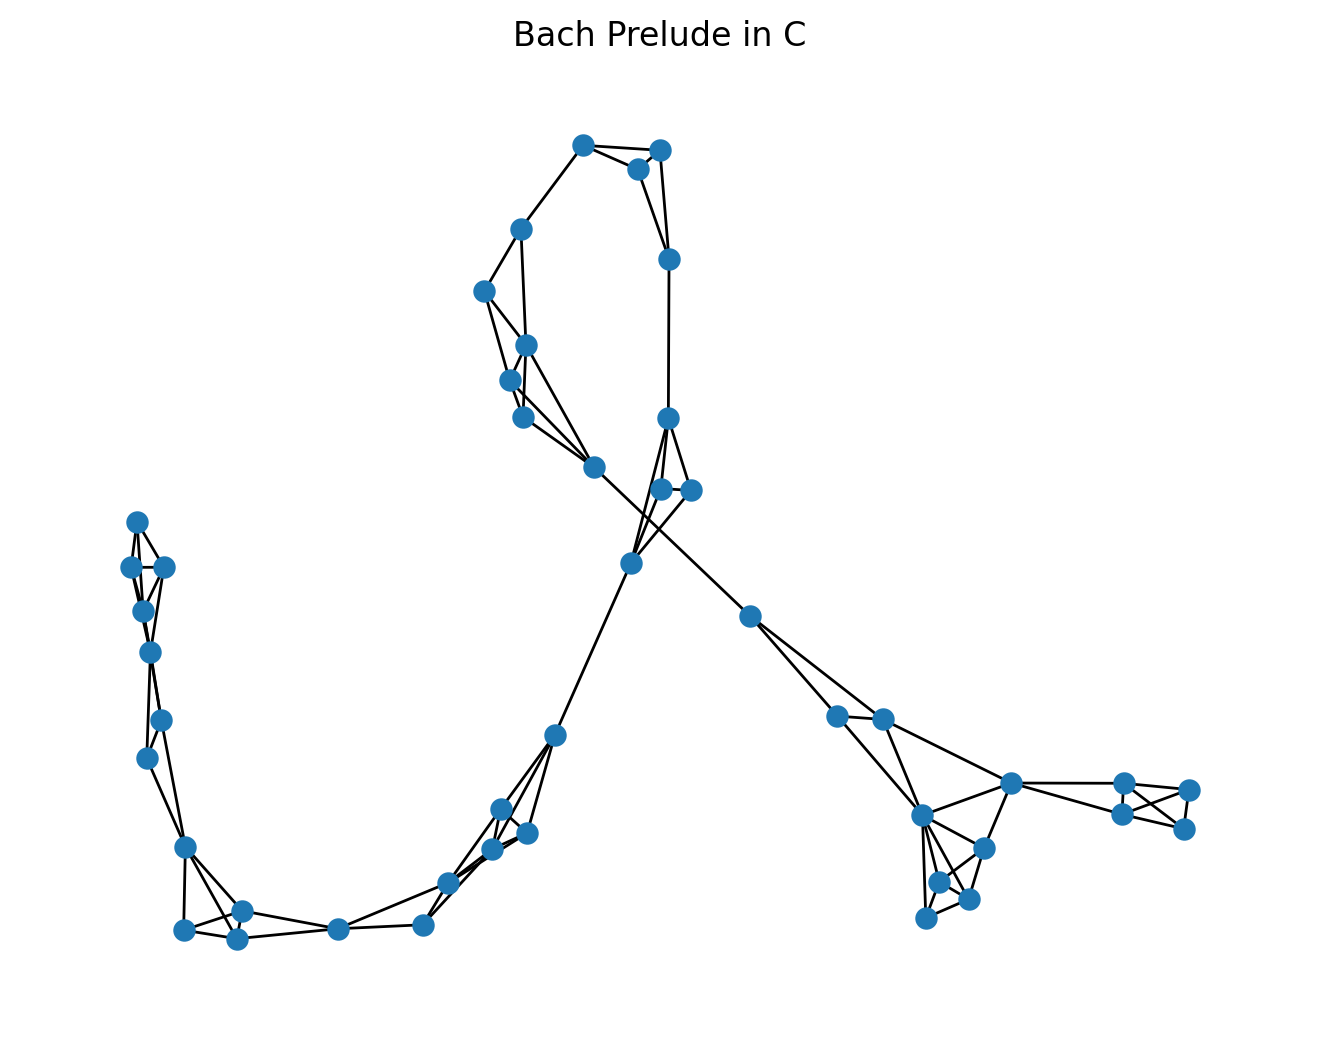

In [51]:
# building KNN Graph
k = 3
distance_matrix = dist_mat
knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

G = nx.from_scipy_sparse_array(knn_graph)

# Detect if the graph is disjoint
if not nx.is_connected(G):
    print("The KNN graph is disjoint. Ensuring connectivity...")

    # Calculate the connected components
    components = list(nx.connected_components(G))

    # Connect the components
    for i in range(len(components) - 1):
        min_dist = np.inf
        closest_pair = None
        for node1 in components[i]:
            for node2 in components[i + 1]:
                dist = distance_matrix[node1, node2]
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (node1, node2)

        # Add an edge between the closest pair of nodes from different components
        G.add_edge(closest_pair[0], closest_pair[1])

# Plot the final connected graph
pos = nx.spring_layout(G, seed=42, iterations=50)
pos_dict = {i: pos[i] for i in range(len(pos))}
nx.draw(G, node_size=50, pos=pos_dict)
plt.title('Bach Prelude in C')
plt.show()

In [52]:
# distance matrix to knn graph function
def distance_matrix_to_knn_graph(k: int, distance_matrix: np.array, graph_title: str,
                                 seed: int, iterations: int):
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  G = nx.from_scipy_sparse_array(knn_graph)

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  # Plot the final connected graph
  pos = nx.spring_layout(G, seed=seed, iterations=iterations)
  nx.draw(G, node_size=50, pos=pos)
  plt.title(graph_title + f" (K={k})")
  plt.show()

The KNN graph is disjoint. Ensuring connectivity...


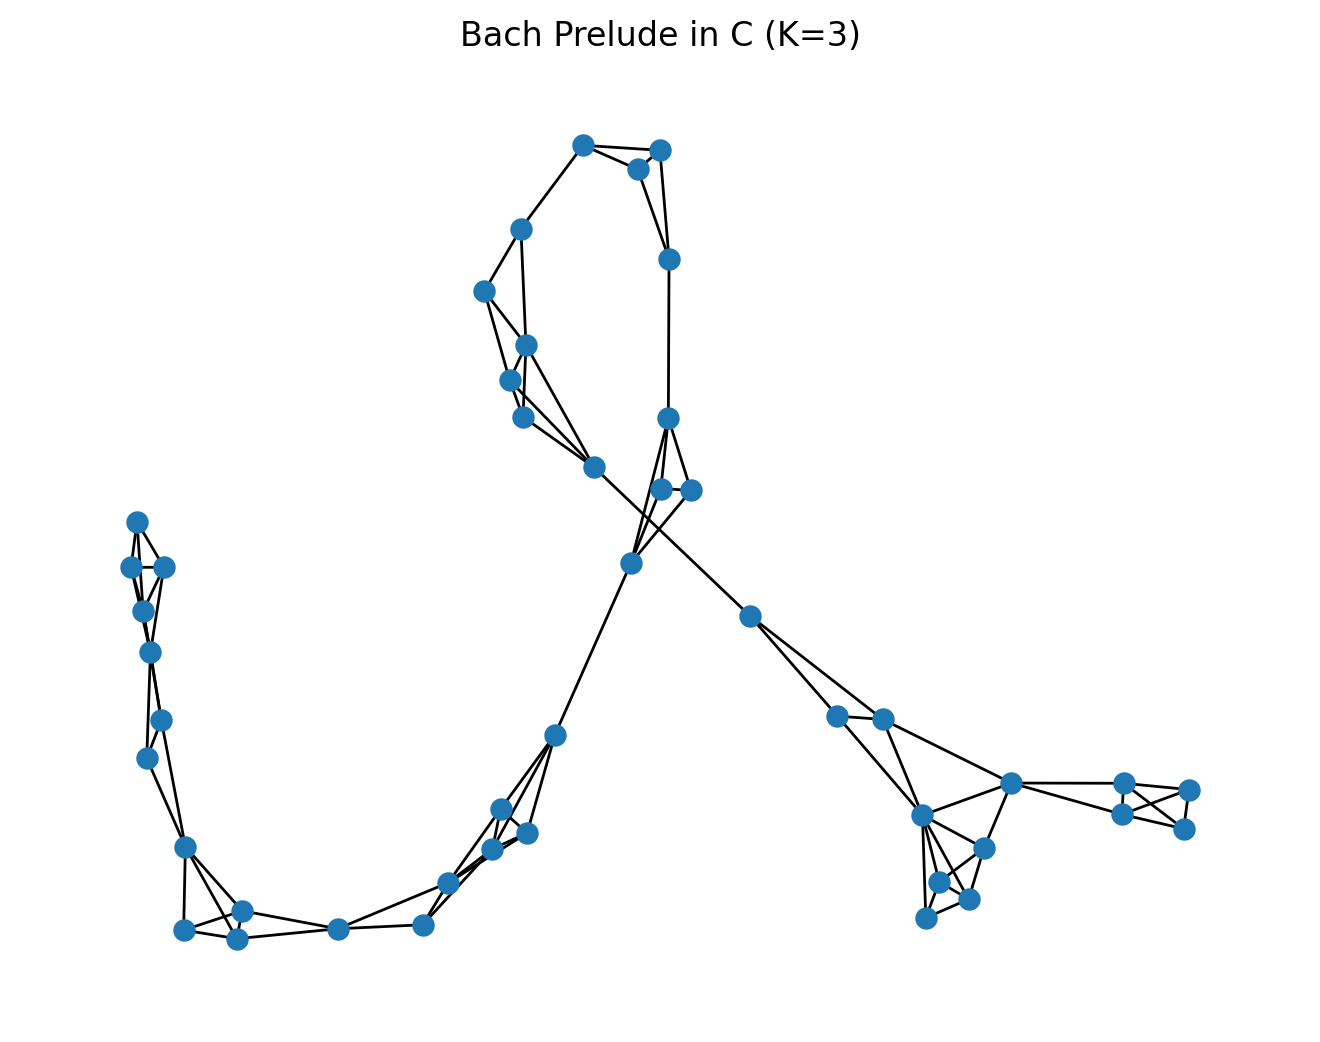

In [53]:
# show graph
distance_matrix_to_knn_graph(3, dist_mat, "Bach Prelude in C", 42, 50)

### Currently Trying to Put The Segment Data Into The Node so we can analyze grouped segments

In [54]:
# segments to graph function
def segments_to_graph(k: int, segments: list[pd.DataFrame], cores=None):
  # Convert segments to a distance matrix
  distance_matrix = segments_to_distance_matrix(segments, cores=cores)

  # Compute the k-NN graph
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  # Convert the k-NN graph to a NetworkX graph
  G = nx.from_scipy_sparse_array(knn_graph)

  # Add segment data as attributes to each node
  for i in range(len(segments)):
    G.nodes[i]['segment'] = segments[i]

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  return G, distance_matrix

In [55]:
# segments to graph
graph, distance_matrix = segments_to_graph(5, segments)

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

## Trying to find ways to validate "Graph Identity"

besides average dtw distance Im trying to see if I can make something of a graph "silhouette score".

Basically get the communities in the graph then calculate the following:

* homogeneity: intra-cluster distance

* heterogeneity: inter-cluster distance

* "Graph Silhoette Score:" $\frac{Heterogeneity - Homogeneity} {max(Hetero, Homo)}$

Also might take a look at clustering coefficients

In [56]:
# graph metrics function
def graph_metrics(graph: nx.classes.graph.Graph, distance_matrix: np.array,
                  seed: int):
  avg_dtw_distance = distance_matrix.mean()
  avg_clustering_coef = nx.average_clustering(graph)

  communities = nx.community.louvain_communities(graph, seed)

  silhouette_scores = []
  for cluster in communities:
    for i in cluster:
      cluster_distances = distance_matrix[i, list(cluster - {i})]
      homogeneity = np.mean(cluster_distances)
      other_cluster_distances = [np.mean(distance_matrix[i, list(other_cluster)]) for other_cluster in communities if other_cluster != cluster]
      heterogeneity = min(other_cluster_distances) if other_cluster_distances else homogeneity
      silhouette_score = (heterogeneity - homogeneity) / max(heterogeneity, homogeneity)
      silhouette_scores.append(silhouette_score)

  # Average silhouette score for all nodes
  average_silhouette_score = np.mean(silhouette_scores)

  conductance_scores = []
  for cluster in communities:
    cluster_conductance = conductance(graph, cluster)
    conductance_scores.append(cluster_conductance)

  average_conductance = np.mean(conductance_scores)

  print("Average DTW Distance:", avg_dtw_distance)
  print("Average Clustering Coefficient:", avg_clustering_coef)
  print("Average Silhouette Score", average_silhouette_score)
  print("Average Conductance:", average_conductance)

In [57]:
# show graph metrics and segment data
graph_metrics(graph, distance_matrix, 42)
print(f"Graph Length: {len(graph)}")

for node in graph.nodes(data=True):
  node_id = node[0]
  segment_data = node[1]['segment']
  print(f"Node {node_id} segment data:")
  print(segment_data)

Average DTW Distance: 393.0947555203654
Average Clustering Coefficient: 0.7135978835978836
Average Silhouette Score 0.4129511661002915
Average Conductance: 0.108109399681792
Graph Length: 45
Node 0 segment data:
    onset_beats  duration_beats  midi_pitch  onset_sec  duration_sec  is_note  \
0          0.00            2.00        60.0   0.000000      1.621622      1.0   
1          0.25            1.75        64.0   1.621622      1.418919      1.0   
2          0.50            0.25        67.0   3.040541      0.202703      1.0   
3          0.75            0.25        72.0   3.243243      0.202703      1.0   
4          1.00            0.25        76.0   3.445946      0.200000      1.0   
5          1.25            0.25        67.0   3.645946      0.202703      1.0   
6          1.50            0.25        72.0   3.848649      0.202703      1.0   
7          1.75            0.25        76.0   4.051351      0.202703      1.0   
8          2.00            2.00        60.0   4.254054     

In [58]:
# plot graph function
def plot_graph(graph: nx.classes.graph.Graph,
               seed: int,
               iterations: int,
               title: str,
               node_size: int):
  pos = nx.spring_layout(graph, seed=seed, iterations=iterations)
  nx.draw(G, node_size=node_size, pos=pos)
  plt.title(title)
  plt.show()

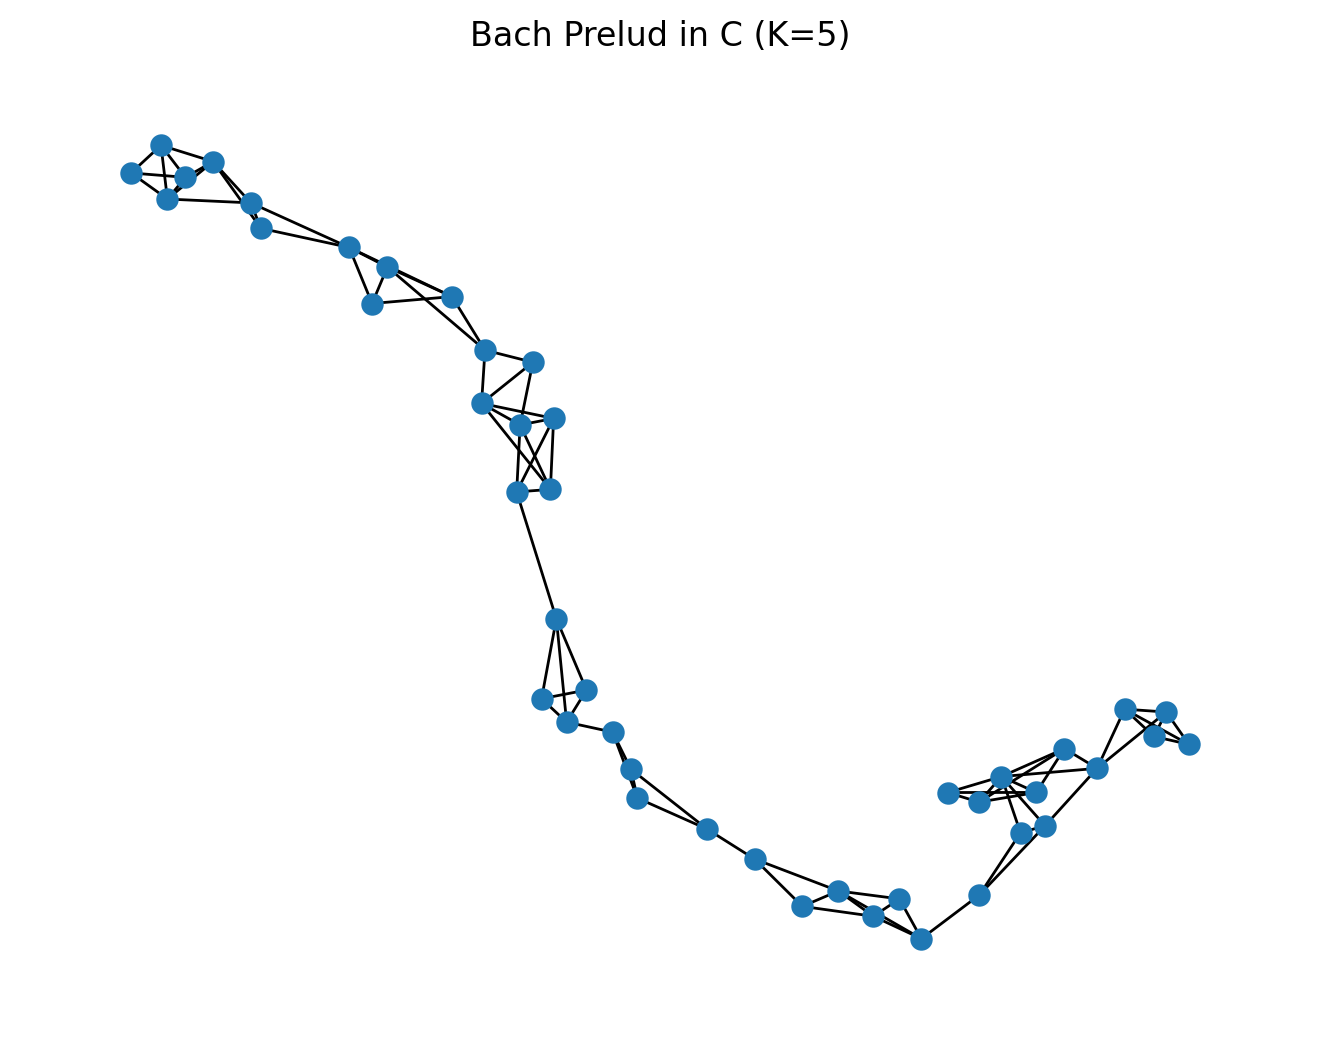

In [59]:
# show graph
plot_graph(graph, 3, 50, "Bach Prelud in C (K=5)", 50)

In [ ]:
for i in range(len(graph.nodes())):
  graph.nodes[i]['segment'] = graph.nodes[i]['segment'].to_json(default_handler=str)

nt = Network('1000px', '1000px', notebook=True, cdn_resources = 'remote')
nt.from_nx(graph)
nt.show('sample_graph.html')   ### Still need to figure out the labels
display(HTML('sample_graph.html'))